In [1]:
import igl
from meshplot import plot
import numpy as np
import pygeodesic.geodesic as geodesic
import networkx as nx
import drawSvg as draw

EPSILON = 1e-5

# find out if new vertex is on the given line segment defined by the two vertices of the edge
def is_vertex_on_line_segment (vertex_A, vertex_B, new_vertex_C):
    result = False
    side_AB = vertex_A - vertex_B
    side_AC = vertex_A - new_vertex_C
    cross_ABAC = np.cross(side_AB, side_AC)
    # if cross product is zero then point is on line, check dot product to find if point lines on the "line segment"
    if np.linalg.norm(cross_ABAC) < EPSILON: #  check if all elements in array are zero
        dot_ABAB = np.dot(side_AB, side_AB)
        dot_ABAC = np.dot(side_AB, side_AC)
        # if dot product is greater than zero but less dot product of line segment with itself point is on the line segment
        if dot_ABAC > 0 and dot_ABAC < dot_ABAB:
            result = True
    return result

# goes through all edges of the mesh and returns the vertex ids of the edge that is intersected by the new vertex
def find_cut_edge_vertex_ids(vertices, faces, new_vertex):
    edges=igl.edges(faces)
    result = False
    for i, edge in enumerate(edges):
        result = is_vertex_on_line_segment(vertices[edge[0]], vertices[edge[1]], new_vertex)
        if result is True:
            cut_edge_vertices = [edge[0], edge[1]]
            break
    return cut_edge_vertices

# goes through the face list and finds the two faces that each have both cut vertex ids
def find_faces_shared_by_cut_edge (cut_edge_vertices, faces):
    first_face = None
    for i, face in enumerate(faces):
        if cut_edge_vertices[0] in face and cut_edge_vertices[1] in face:
            if first_face is None:
                first_face = i
            else:
                return first_face, i
    raise Exception ('did not find face {}'.format (cut_edge_vertices))

# Splits the two faces into two new faces and adds them to the list, deletes the old ones
def cut_face_in_two (faces, shared_face_ids, cut_edge_vertices, new_vertex_id):
    cut_face_1 = faces [shared_face_ids[0]]
    # Repeat for the other shared face
    cut_face_2 = faces [shared_face_ids[1]]
    
    # create copies of the orignal face
    face_1 = np.copy(cut_face_1)
    face_2 = np.copy(cut_face_1)
    face_3 = np.copy(cut_face_2)
    face_4 = np.copy(cut_face_2)
    
    # Replace the edge vertices with the new vertex in each copy
    face_1[face_1 == cut_edge_vertices[0]] = new_vertex_id
    face_2[face_2 == cut_edge_vertices[1]] = new_vertex_id
    face_3[face_3 == cut_edge_vertices[0]] = new_vertex_id
    face_4[face_4 == cut_edge_vertices[1]] = new_vertex_id
    
    # Delete the orignal face and append the new faces
    faces = np.delete(faces, [shared_face_ids[0],shared_face_ids[1]], axis = 0)
    faces = np.append(faces, [face_1], axis = 0)
    faces = np.append(faces, [face_2], axis = 0)
    faces = np.append(faces, [face_3], axis = 0)
    faces = np.append(faces, [face_4], axis = 0)

    return faces

#----------functions from the previous lecture "edge unfolding polyhedra"-----------

# adds edges based on the adjacency of faces in the mesh
def add_edges_from_mesh(graph, faces):
    face_adjacency_matrix, _ = igl.triangle_triangle_adjacency(faces)
    for face_id, _ in enumerate(faces):
        for ajd_face_id in face_adjacency_matrix[face_id]:
            graph.add_edge(face_id,ajd_face_id)
            

# adds nodes to graph G for every face in mesh
def add_nodes_from_mesh(graph, faces): [graph.add_node(face_id) for face_id, face in enumerate(faces)]

# create networkx graph from given mesh
def graph_from_mesh(faces):
    graph = nx.Graph()
    add_nodes_from_mesh(graph, faces)
    add_edges_from_mesh(graph, faces)
    return graph

# returns a rotation matrix from a (unnormalized) axis and an angle
def get_rotation_matrix(axis, angle):
    from scipy.spatial.transform import Rotation
    return Rotation.from_rotvec(axis/np.linalg.norm(axis) * angle).as_matrix()

# returns a matrix that maps 3D space onto a 2D plane (the orientation of which is specified by 'face_normal').
def get_2d_projection(face_normal):
    xy_plane_normal = np.array([0,0,1])  #  aka 'the z-axis'
    rotation_axis = np.cross(face_normal, xy_plane_normal)
    angle = np.arccos(np.clip(np.dot(xy_plane_normal, face_normal), -1.0, 1.0))

    discard_z_matrix = np.array([
        [1, 0, 0],
        [0, 1, 0]
    ])

    rotation_matrix = get_rotation_matrix(rotation_axis, angle)
    return discard_z_matrix.dot(rotation_matrix)

# find commone edge of two adjacent faces
def find_common_edge(faces, face_id_a, face_id_b):
    # make sure that the resulting vertex ids are clockwise wrt. source face
    face_vertex_array_a = faces[face_id_a]
    face_vertex_array_b = faces[face_id_b]

    for i in range(3):
        if face_vertex_array_a[i] in face_vertex_array_b and face_vertex_array_a[(i+1) % 3] in face_vertex_array_b:
            return (face_vertex_array_a[i], face_vertex_array_a[(i+1) % 3])

    return None

def get_face_normal(vertices, faces, face_id):
    face_normals = igl.per_face_normals(vertices, faces, np.ones((1, 3)))
    return face_normals[face_id]

# get angle between the normals of two faces
def dihedral_angle(vertices, faces, face_a_id, face_b_id):
    face_normals = igl.per_face_normals(vertices, faces, np.ones((1, 3)))
    return np.arccos(np.clip(np.dot(face_normals[face_a_id], face_normals[face_b_id]), -1.0, 1.0))

# update from edge unfolding: added "spanning_tree" as an input instead of generating graph inside the function from the vertices and faces
def unfold(vertices, faces, spanning_tree):
    polygons = []  # resulting polygons, represented as lists of 2D coordinates

    source_face_id = 0
    parent_dict = nx.dfs_predecessors(spanning_tree, source=source_face_id)  # format { node_id: parent_id, ... }
    parent_dict[source_face_id] = None  # add the source face, as networkX is not doing this by default

    for face_id, parent_face_id in parent_dict.items():
        # retrieve the coordinates of current face
        face_coordinates = [vertices[vertex_id] for vertex_id in faces[face_id]]
        
        # iterate over all parents and apply unfolding rotations accordingly
        selected_face_id = face_id
        selected_parent_face_id = parent_face_id

        while selected_face_id != source_face_id:
            # get edge between selected face and parent as tuple of two vertex_ids
            hinge_edge = find_common_edge(faces, selected_parent_face_id, selected_face_id)
            
            # apply unfolding transformation:
            # - all face_coordinates are offset such that the hinge_edge aligns with the origin
            # - then, the rotation around the hinge_edge is performed, such that the selected face
            #   and the parent lay in the same plane
            # - finally, we reverse the offset, such that the face ends up in its original position 
            offset = vertices[hinge_edge[0]]
            rotation_angle = dihedral_angle(
                vertices, faces, selected_face_id, selected_parent_face_id)
            rotation_axis = vertices[hinge_edge[0]] - vertices[hinge_edge[1]]
            rotation_matrix = get_rotation_matrix(rotation_axis, rotation_angle)

            for i in range(3):
                face_coordinates[i] = rotation_matrix.dot(face_coordinates[i] - offset) + offset

            # climbing up the tree
            selected_face_id = selected_parent_face_id
            selected_parent_face_id = parent_dict[selected_parent_face_id]

        # project 3D coordinates into the 2D plane that 
        for i in range(3):
            face_coordinates[i] = get_2d_projection(get_face_normal(vertices, faces, source_face_id)).dot(face_coordinates[i])
            
        polygons.append(face_coordinates)

    return polygons

C:\miniconda3\lib\site-packages\jupyter_client\session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.4901161…

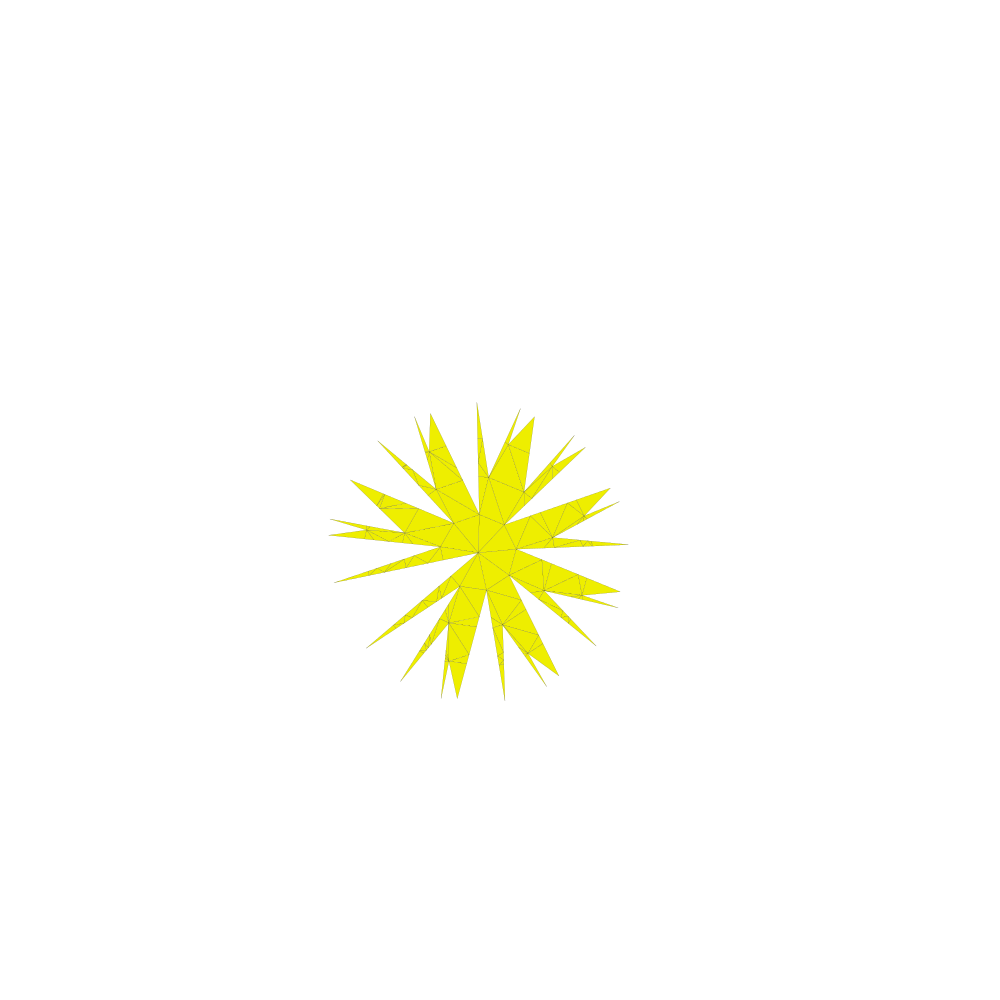

In [2]:
raw_vertices, raw_faces = igl.read_triangle_mesh("sphere.stl")
vertices, faces, _ = igl.remove_duplicates(raw_vertices, raw_faces, 0.00001)

# Define the source id and end id with respect to the vertex array
source_id = 0
end_id = len(vertices)
geodesic_paths = []

# Loop through all the vertices of the mesh as target ids
for i in range (1, end_id):
        # Define the target vertex id with respect to the vertex array
        target_id = i
        # add the vertex id of the target vertex to the current geodesic path
        geodesic_path = [target_id]
        # Initialise the PyGeodesicAlgorithmExact class instance
        # Reinitialise with update mesh after each path is created otherwise incorrect edges will be created
        geoalg = geodesic.PyGeodesicAlgorithmExact(vertices, faces)
        # Compute the geodesic distance and the path. 
        _, path = geoalg.geodesicDistance(source_id, target_id)  #  path is in order from target to source.
        # Faces are cut only if paths are longer than two vertices
        if len(path) > 2:
            # ignore the first and last vertex as they are already in the array
            for vertex_id in range (1, len(path)-1):
                # add path vertex to mesh vertex list
                vertices = np.append(vertices, [path[vertex_id]], axis=0)
                # obtain vertex id of newly added vertex
                new_vertex_id = len(vertices) - 1
                # find the vertex ids of the edge that the new vertex is located on
                cut_edge_vertices = find_cut_edge_vertex_ids(vertices, faces, path[vertex_id])
                # find the two faces that share the edge
                shared_face_ids = find_faces_shared_by_cut_edge (cut_edge_vertices, faces)
                # create two new faces/face and add them to the face list. Delete the two orignal faces
                faces = cut_face_in_two (faces, shared_face_ids, cut_edge_vertices, new_vertex_id)
                # add the vertex id of the newly created vertex to the current geodesic path
                geodesic_path.append(new_vertex_id)
        # add the vertex id of the source vertex to the current geodesic path
        geodesic_path.append(source_id)
        geodesic_paths.append(geodesic_path)

# initialize a networkx graph from the faces
graph = graph_from_mesh(faces)

for path in geodesic_paths:
    for i in range(len(path)-1):
        cut_edge_vertices = [path[i], path[i+1]]
        shared_face_ids = find_faces_shared_by_cut_edge (cut_edge_vertices, faces)
        graph.remove_edge(shared_face_ids[0],shared_face_ids[1])  #dont care about directionality since the graph is undirected

# #check if graph is tree
# print(nx.is_tree(graph))    

p = plot(vertices, faces, return_plot=True)
p.add_points(vertices, shading={"point_color": "black","point_size": 0.4})
p.add_edges(vertices, faces, shading={"line_color": "red"});

#TODO unfold along the spanning tree. Use the functions you created in the last lecture
#ref: https://github.com/HassoPlattnerInstituteHCI/Algorithmic-Folding/blob/Unfolding/01/Notebook_unfolding.ipynb
polygons = unfold(vertices, faces, graph)

# generate svg visualization
drawing = None
drawing = draw.Drawing(1000, 1000, origin='center')
for polygon in polygons:
    # polygon = [coords[0:2] for coords in polygon]
    drawing.append(draw.Lines(*np.array(polygon).flatten()*50,
                   close=True, fill='#eeee00', stroke='#000', stroke_width=.1))

drawing.rasterize()
drawing

# # code to modify the cube to make it easier to understand
# new_vertex = [0,1,0]
# new_vertex_id = 0
# vertices = np.insert(vertices, 0, [new_vertex], axis=0)
# faces = faces + 1 #Since the vertice is inserted at the top the mapping also needs to be shifted
# cut_edge_vertices = find_cut_edge_vertex_ids(vertices, faces, new_vertex)
# shared_face_ids = find_faces_shared_by_cut_edge (cut_edge_vertices, faces)
# faces = cut_face_in_two (faces, shared_face_ids, cut_edge_vertices, new_vertex_id)
#igl.write_triangle_mesh('./modified_cube.stl',vertices, faces, True)